In [89]:
from ler.utils import interpolator_pickle_path, get_param_from_json, cubic_spline_interpolator, append_json, cubic_spline_interpolator2d_array, inverse_transform_sampler, pdf_cubic_spline_interpolator2d_array, interpolator_sampler_conditioned, save_json, load_json, save_pickle, load_pickle
from ler.lens_galaxy_population import phi
import numpy as np
from scipy.integrate import quad, cumulative_trapezoid
from scipy.interpolate import interp1d, CubicSpline
from numba import njit
import matplotlib.pyplot as plt

In [59]:
dict_list = [{"name": "lens_mass", "type": "cubic_spline", "x": np.array([0, 1, 2, 3]), "y": [0, 1, 0, 1], "z": None}, ]

append_json("test.json", dict_list, replace=True)

[{'name': 'lens_mass',
  'type': 'cubic_spline',
  'x': array([0, 1, 2, 3]),
  'y': [0, 1, 0, 1],
  'z': None}]

In [64]:
if isinstance(load_json("test.json")[0]['z'], type(None)):
    print("None")
else:
    print("Not None")

None


In [92]:
class FuntionConditioning():

    def __init__(self,
        function,  # can also be an array of function values 
        x_array,
        conditioned_y_array=None,  # if this is not none, 2D interpolation will be used
        param_dict_given={},
        directory='./interpolator_pickle',
        sub_directory='default',
        name='default',
        create_new=False,
        create_function=True,
        create_function_inverse=False,
        create_pdf=True,
        create_rvs=True,
    ):

        # create_interpolator input list
        input_list = [function, x_array, conditioned_y_array, create_function_inverse,create_pdf, create_rvs]

        # check first whether the directory, subdirectory and pickle exist
        path_inv_cdf, it_exist = interpolator_pickle_path(
            param_dict_given=param_dict_given,
            directory=directory,
            sub_directory=sub_directory,
            interpolator_name=name,
        )

        # if the interpolator exists, load it
        if create_new:
            it_exist = False

        if it_exist:
            print(f"{name} interpolator will be loaded from {path_inv_cdf}")
            # load the interpolator
            interpolator = load_pickle(path_inv_cdf)
        else:
            print(f"{name} interpolator will be generated at {path_inv_cdf}")
            interpolator = self.create_interpolator(*input_list)
            # save the interpolator
            save_pickle(path_inv_cdf, interpolator)

        x_array = interpolator['x_array']
        z_array = interpolator['z_array']
        y_array = interpolator['conditioned_y_array']
        function_spline = interpolator['function_spline']
        function_inverse_spline = interpolator['function_inverse_spline']
        pdf_norm_const = interpolator['pdf_norm_const']
        cdf_values = interpolator['cdf_values']

        self.function_spline = function_spline

        if y_array == None:
            print(f"y_array None: {y_array}")
            # function is 1D
            self.function = njit(lambda x: cubic_spline_interpolator(x, function_spline, x_array)) if create_function else None
            # function_inverse is 1D
            self.function_inverse = njit(lambda x: cubic_spline_interpolator(x, function_inverse_spline, z_array)) if create_function_inverse else None
            # pdf is 1D
            self.pdf = njit(lambda x: cubic_spline_interpolator(x, function_spline, x_array)/pdf_norm_const) if create_pdf else None
            # sampler is 1D
            self.rvs = njit(lambda size: inverse_transform_sampler(size, cdf_values, x_array)) if create_rvs else None
            
        else:
            print(f"y_array not None: {y_array}")
            self.none = y_array
            self.function = njit(lambda x, y: cubic_spline_interpolator2d_array(x, y, function_spline, x_array, y_array)) if create_function else None

            self.function_inverse = njit(lambda x, y: cubic_spline_interpolator2d_array(x, y, function_inverse_spline, z_array, y_array)) if create_function_inverse else None

            self.pdf = njit(lambda x, y: pdf_cubic_spline_interpolator2d_array(x, y, pdf_norm_const, function_spline, x_array, y_array)) if create_pdf else None

            self.rvs = njit(lambda size, y: interpolator_sampler_conditioned(size, y, cdf_values, x_array, y_array)) if create_rvs else None

        self.x_array = x_array
        self.z_array = z_array
        
        self.conditioned_y_array = y_array
        self.function_spline = function_spline
        self.function_inverse_spline = function_inverse_spline
        self.pdf_norm_const = pdf_norm_const
        self.cdf_values = cdf_values


    def create_interpolator(self, function, x_array, conditioned_y_array, create_function_inverse, create_pdf, create_rvs):

        # function can be numpy array or callable
        # x_array, z_array are 2D arrays if conditioned_y_array is not None
        x_array, z_array, conditioned_y_array = self.create_z_array(x_array, function, conditioned_y_array)
        del function

        function_spline = self.function_spline_generator(x_array, z_array, conditioned_y_array)

        function_inverse_spline = self.function_spline_generator(z_array, x_array, conditioned_y_array) if create_function_inverse else None

        if create_pdf:
            pdf_norm_const = self.pdf_norm_const_generator(x_array, function_spline, conditioned_y_array)

            if create_rvs:
                cdf_values = self.cdf_values_generator(x_array, z_array, pdf_norm_const, conditioned_y_array)
            else:
                cdf_values = None
        else:
            pdf_norm_const = None
            cdf_values = None
            
        return {
            'x_array': x_array,
            'z_array': z_array,
            'conditioned_y_array': conditioned_y_array,
            'function_spline': function_spline,
            'function_inverse_spline': function_inverse_spline,
            'pdf_norm_const': pdf_norm_const,
            'cdf_values': cdf_values,
        }

    def create_z_array(self, x_array, function, conditioned_y_array):

        if callable(function):
            if conditioned_y_array is None:
                z_array = function(x_array)
                # remove nan values
                idx = np.argwhere(np.isnan(z_array))
                x_list = np.delete(x_array, idx)
                z_list = np.delete(z_array, idx)

            else:
                idx = np.argsort(conditioned_y_array)
                conditioned_y_array = conditioned_y_array[idx]
                # x_array is 2D here, each row corresponds to a different y value
                x_array = x_array[idx]

                z_list = []
                x_list = []
                for i, y in enumerate(conditioned_y_array):
                    x_ = np.sort(x_array[i])
                    try:
                        z_ = function(x_, y)
                    except:
                        z_ = function(x_, y*np.ones_like(x_))

                    idx = np.argwhere(np.isnan(z_))
                    x_list.append(np.delete(x_, idx))
                    z_list.append(np.delete(z_, idx))

        else:
            if conditioned_y_array is None:
                z_array = function
                # remove nan values
                idx = np.argwhere(np.isnan(z_array))
                x_list = np.delete(x_array, idx)
                z_list = np.delete(z_array, idx)
            else:
                # row sort
                idx = np.argsort(conditioned_y_array)
                conditioned_y_array = conditioned_y_array[idx]
                # x_array is 2D here, each row corresponds to a different y value
                x_array = x_array[idx]
                z_array = function[idx]

                z_list = []
                x_list = []
                for i in range(len(conditioned_y_array)):
                    # column sort
                    idx = np.argsort(x_array[i])
                    x_ = x_array[i][idx]
                    z_ = z_array[i][idx]
                    idx = np.argwhere(np.isnan(z_))
                    x_list.append(np.delete(x_, idx))
                    z_list.append(np.delete(z_, idx))


        return np.array(x_list), np.array(z_list), conditioned_y_array

    def cdf_values_generator(self, x_array, z_array, pdf_norm_const, conditioned_y_array):
        # 1D case
        if conditioned_y_array is None:
            z_array[z_array<0.] = 0.
            cdf_values = cumulative_trapezoid(z_array/pdf_norm_const, x_array, initial=0)
        # 2D case
        else:
            cdf_values = []
            for i, y in enumerate(conditioned_y_array):
                z_array_ = z_array[i]
                z_array_[z_array_<0.] = 0.
                pdf_norm_ = pdf_norm_const[i]
                cdf_values.append(cumulative_trapezoid(z_array_/pdf_norm_, x_array[i], initial=0))

        return np.array(cdf_values)
    
    def pdf_norm_const_generator(self, x_array, function_spline, conditioned_y_array):
        # 1D case
        if conditioned_y_array is None:
            pdf_unorm = lambda x: cubic_spline_interpolator(np.array([x]), function_spline, x_array)

            norm = quad(pdf_unorm, min(x_array), max(x_array))[0]
            return norm
        # 2D case
        else:
            norm = []
            for i, y in enumerate(conditioned_y_array):
                pdf_unorm = lambda x: cubic_spline_interpolator(np.array([x]), function_spline[i], x_array[i])

                norm.append(quad(pdf_unorm, min(x_array[i]), max(x_array[i]))[0])

            return np.array(norm)
    
    def function_spline_generator(self, x_array, z_array, conditioned_y_array):
        # 1D case
        if conditioned_y_array is None:
            function_spline = CubicSpline(x_array, z_array).c
        # 2D case
        else:
            function_spline = []
            for i, y in enumerate(conditioned_y_array):
                function_spline.append(CubicSpline(x_array[i], z_array[i]).c)
            
        return np.array(function_spline)

In [83]:
# x_array = np.load('x_array.npy')
# y_array = np.load('y_array.npy')
# z_array = np.load('z_array.npy')

from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
Dc = lambda z_: cosmo.comoving_distance(z_).value
x_array = np.geomspace(0.001, 10.0, 1000)
z_array = Dc(x_array)

In [93]:
#1D sucess, loading and saving also works
test = FuntionConditioning(
    param_dict_given={'dimension': 1},
    function=Dc,
    x_array=x_array,
    # conditioned_y_array=y_array,
    create_new=True,
)
# test2 = FuntionConditioning(
#     param_dict_given={'dimension': 2},
#     function=z_array,
#     x_array=x_array,
#     conditioned_y_array=y_array,
#     create_new=False,
# )

default interpolator will be generated at ./interpolator_pickle/default/default_1.json
y_array None: None


In [78]:
test.none==None

True

In [72]:
dict_ = load_json('./interpolator_pickle/default/default_1.json')

In [25]:
dict_.keys()

dict_keys(['x_array', 'z_array', 'conditioned_y_array', 'function_spline', 'pdf_norm_const', 'cdf_values'])

In [34]:
type(dict_['conditioned_y_array'])

NoneType

In [88]:
test.pdf(np.array([0.1,1.112, 2., 2.223]))
# test.rvs?
#test2.pdf(np.array([0.1,1.112, 2., 2.223]), np.array([0.1,1.112, 2., 2.223]))

array([9.51914935e-10, 1.05860187e-08, 1.90405000e-08,
       2.11637648e-08])

In [20]:
y = test2.conditioned_y_array
ynew = 0.01

y_idx = np.searchsorted(y, ynew) - 1 if ynew > y[0] else 0
if ynew > y[y_idx] + (y[y_idx+1] - y[y_idx]) / 2:
    y_idx = y_idx + 1

print(y_idx, y[y_idx], ynew)

0 0.001 0.01


In [25]:
cubic_spline_interpolator(np.linspace(0.0, 0.01, 100), test2.function_spline[y_idx], test2.x_array[y_idx])

SyntaxError: incomplete input (3513201128.py, line 1)

In [12]:
y1d = test2.conditioned_y_array
conditioned_y = 1.0
y_idx = np.searchsorted(y1d, conditioned_y) - 1 if conditioned_y > y1d[0] else 0
print(y_idx)

cdf2d = test2.cdf_values
x2d = test2.x_array
cdf = cdf2d[y_idx]
x = x2d[y_idx]

size = 10
u = np.random.uniform(0, 1, size)
idx = np.searchsorted(cdf, u)
# x1, x0, y1, y0 = cdf[idx], cdf[idx-1], x[idx], x[idx-1]
# samples = y0 + (y1 - y0) * (u - x0) / (x1 - x0)
u, idx

9


(array([0.8287399 , 0.21013327, 0.86829262, 0.37377619,
        0.50097759, 0.18257978, 0.07358526, 0.97963767,
        0.19944918, 0.69241226]),
 array([67, 26, 70, 36, 42, 24, 15, 86, 26, 55]))

In [30]:
test2.x_array[y_idx].min(), test2.x_array[y_idx].max()

(0.0, 0.001)

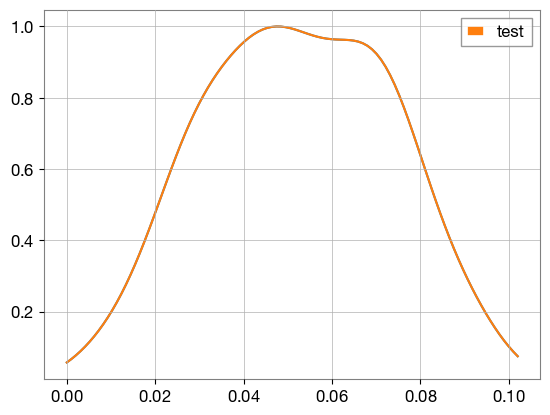

In [46]:
y_idx = 1
# plt.plot(test2.x_array[y_idx],test2.cdf_values[y_idx])
plt.plot(test2.x_array[y_idx],test2.z_array[y_idx])

spline = CubicSpline(test2.x_array[y_idx], test2.z_array[y_idx]).c

plt.plot(test2.x_array[y_idx], cubic_spline_interpolator(np.linspace(0.0, test2.conditioned_y_array[y_idx], 100), spline, test2.x_array[y_idx]), label='test')
plt.legend()


plt.show()

In [10]:
# integrate test2.pdf with quad
y_idx = 0
y = test2.conditioned_y_array[y_idx]
integrand = lambda x: test2.pdf(np.array([x]), np.array([y]))[0]

quad(integrand, 0.0, y)

(1.0000000088986405, 1.0460726803139762e-08)

In [9]:
test2.conditioned_y_array

array([1.00000000e-03, 1.09749877e-03, 1.20450354e-03,
       1.32194115e-03, 1.45082878e-03, 1.59228279e-03,
       1.74752840e-03, 1.91791026e-03, 2.10490414e-03,
       2.31012970e-03, 2.53536449e-03, 2.78255940e-03,
       3.05385551e-03, 3.35160265e-03, 3.67837977e-03,
       4.03701726e-03, 4.43062146e-03, 4.86260158e-03,
       5.33669923e-03, 5.85702082e-03, 6.42807312e-03,
       7.05480231e-03, 7.74263683e-03, 8.49753436e-03,
       9.32603347e-03, 1.02353102e-02, 1.12332403e-02,
       1.23284674e-02, 1.35304777e-02, 1.48496826e-02,
       1.62975083e-02, 1.78864953e-02, 1.96304065e-02,
       2.15443469e-02, 2.36448941e-02, 2.59502421e-02,
       2.84803587e-02, 3.12571585e-02, 3.43046929e-02,
       3.76493581e-02, 4.13201240e-02, 4.53487851e-02,
       4.97702356e-02, 5.46227722e-02, 5.99484250e-02,
       6.57933225e-02, 7.22080902e-02, 7.92482898e-02,
       8.69749003e-02, 9.54548457e-02, 1.02000000e-01,
       1.04761575e-01, 1.14975700e-01, 1.26185688e-01,
       1.3

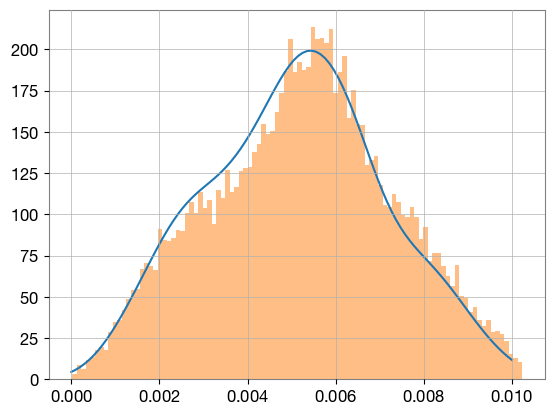

In [12]:
x_max = 0.01
x_values = np.linspace(0.0, x_max, 100)
#test.function(x_values)
plt.plot(x_values, test2.pdf(x_values, x_max*np.ones_like(x_values)), label='function')
# plt.plot(x_values, test2.function(x_values, test2.conditioned_y_array[1]*np.ones_like(x_values)), label='function')
plt.hist(test2.rvs(20000, x_max), bins=100, density=True, alpha=0.5, label='rvs')

# x_max = test2.conditioned_y_array[2]
# x_values = np.linspace(0.0, x_max, 100)
# plt.plot(x_values, test2.function(x_values, x_max*np.ones_like(x_values)), label='function2')

# idx = np.searchsorted(y_array, x_max)
#plt.plot(x_array[idx], z_array[idx], 'o', label='data')
plt.show()

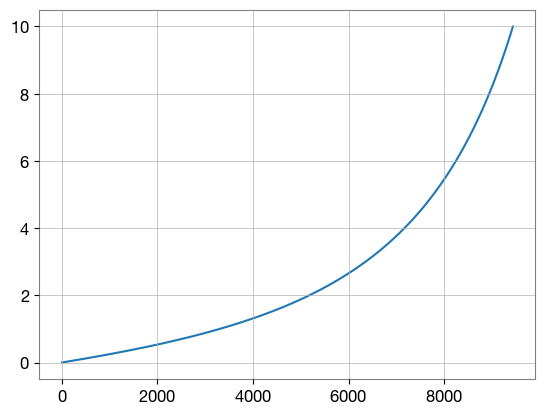

In [44]:
# x_values = np.linspace(0., 10., 100)
#test.function(x_values)
#plt.plot(x_values, test.function(x_values), label='function')
plt.plot(z_array, test.function(z_array), label='inv function')
#plt.plot(x_array[-1], z_array[-1], 'o', label='data')
#plt.plot(z_array[-1], x_array[-1], 'o', label='data')
plt.show()

In [3]:
# numpy 2d norm, with different mu and sigma for each row

In [52]:
from ler.lens_galaxy_population import LensGalaxyParameterDistribution

ler = LensGalaxyParameterDistribution()


Initializing LensGalaxyParameterDistribution class...


Initializing OpticalDepth class

z_to_Dc interpolator will be loaded from ./interpolator_pickle/z_to_Dc/z_to_Dc_0.pickle
Dc_to_z interpolator will be loaded from ./interpolator_pickle/Dc_to_z/Dc_to_z_0.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_0.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_1.pickle
velocity_dispersion_ewoud interpolator will be loaded from ./interpolator_pickle/velocity_dispersion/velocity_dispersion_ewoud_0.pickle
Using pre-gererated axis ratio rayleigh pdf coefficients...
axis_ratio_rayleigh interpolator will be loaded from ./interpolator_pickle/axis_ratio/axis_ratio_rayleigh_0.pickle
axis_ratio sampler: CPUDispatcher(<function OpticalDepth.axis_ratio_rayleigh.<locals>.sampler at 0x342589240>) has been set.
Inter

In [66]:
# scipy kde
import numpy as np
import scipy.stats as stats

y_array1 = np.linspace(0.001, 10, 200)
y_array2 = np.geomspace(0.001, 10, 200)
# unique
y_array = np.unique(np.concatenate([y_array1, y_array2]))

x_size = 200
x_list = []
z_list = []
for i, y in enumerate(y_array):
    x_sample = ler.sample_lens_redshift(y*np.ones(x_size))
    # find kde
    kde = stats.gaussian_kde(x_sample)
    x_array = np.linspace(0.0, y, x_size)
    z_array = kde(x_array) 
    z_array /= np.max(z_array)
    x_list.append(x_array)
    z_list.append(z_array)
x_array = np.array(x_list)
z_array = np.array(z_list)
del x_list, z_list

In [55]:
# np save x_array, z_array, y_array
np.save('x_array.npy', x_array)
np.save('z_array.npy', z_array)
np.save('y_array.npy', y_array)

In [20]:
np.geomspace(0.001, 10, 500)

array([1.00000000e-03, 1.01862899e-03, 1.03760502e-03, ...,
       9.63757866e+00, 9.81711702e+00, 1.00000000e+01])

In [1]:
@njit
def interpolator_sampler_conditioned(size, conditioned_y, cdf2d, x2d, y1d):
    """
    Function to find sampler interpolator coefficients from the conditioned y.
    """

    # xnew = xnew_array[i]
    # ynew = ynew_array[i]

    len_y = len(y1d)
    # find the index nearest to the ynew in y
    y_idx = np.searchsorted(y, ynew) - 1 if ynew > y[0] else 0
    if ynew > y[y_idx] + (y[y_idx+1] - y[y_idx]) / 2:
        y_idx = y_idx + 1

    if (ynew>y[0]) and (ynew<y[1]):
        # linear scaling
        # new cdf values 
        x1, x0, y1, y0 = y1d[1], y1d[0], cdf2d[1], cdf2d[0]
        cdf = y0 + (y1 - y0) * (conditioned_y - x0) / (x1 - x0)
        # new x values
        # x=x2d[0], if all rows are same 
        x1, x0, y1, y0 = y1d[1], y1d[0], x2d[1], x2d[0]
        x = y0 + (y1 - y0) * (conditioned_y - x0) / (x1 - x0)

    elif y_idx == 0:  # lower end point
        cdf = cdf2d[0]
        x = 
        # print("a")
    elif y_idx+1 == len_y:  # upper end point
        result_array.append(cubic_spline_interpolator(np.array([xnew]), coefficients[-1], x[-1])[0]/norm_array[-1])
        # print("b")
    elif y_idx+2 == len_y:  # upper end point
        result_array.append(cubic_spline_interpolator(np.array([xnew]), coefficients[-1], x[-1])[0]/norm_array[-1])
        # print("b")
    else:



    if conditioned_y <= y1d[0]:
        y_idx = 0
    elif conditioned_y >= y1d[-1]:
        y_idx = len(y1d)-1
    else:
        y_idx = np.searchsorted(y1d, conditioned_y)


    x = x2d[y_idx]

    u = np.random.uniform(0, 1, size)
    idx = np.searchsorted(cdf, u)
    x1, x0, y1, y0 = cdf[idx], cdf[idx-1], x[idx], x[idx-1]
    samples = y0 + (y1 - y0) * (u - x0) / (x1 - x0)
    return samples

SyntaxError: invalid syntax (4081325474.py, line 28)